# RNN Text Classification: Predict the sentiment of IMDB movie reviews

In [ ]:
# Download stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import random
import re
from collections import Counter
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from IPython.core.display import display, HTML
from google_drive_downloader import GoogleDriveDownloader as gdd

# Make plots look pretty
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.style.use('ggplot')

tqdm.pandas()

In order to perform deep learning on a GPU (so that everything runs super quick!), CUDA has to be installed and configured. Fortunately, Google Colab already has this set up, but if you want to try this on your own GPU, you can [install CUDA from here](https://developer.nvidia.com/cuda-downloads). Make sure you also [install cuDNN](https://developer.nvidia.com/cudnn) for optimized performance.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Download the training data

This is a dataset of positive and negative IMDB reviews. We can download the data from a public Google Drive folder.

In [ ]:
DATA_PATH = 'data/imdb_reviews.csv'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id='1zfM5E6HvKIe7f3rEt1V2gBpw5QOSSKQz',
        dest_path=DATA_PATH,
    )

## Preprocess the text

In [ ]:
def remove_rare_words(tokens, common_tokens, max_len):
    return [token if token in common_tokens
            else '<UNK>' for token in tokens][-max_len:]


def tokenize(text, stop_words):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    tokens = wordpunct_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    return tokens


class ImdbSentimentDataset(Dataset):
    def __init__(self, data_path, max_vocab, max_len):
        df = pd.read_csv(data_path)

        # Clean and tokenize
        stop_words = set(stopwords.words('english'))
        df['tokens'] = df.review.progress_apply(
            partial(tokenize, stop_words=stop_words),
        )

        # Replace rare words with <UNK>
        all_tokens = [sublst for lst in df.tokens.tolist() for sublst in lst]
        common_tokens = set(list(zip(
            *Counter(all_tokens).most_common(max_vocab)))[0])
        df.loc[:, 'tokens'] = df.tokens.progress_apply(
            partial(
                remove_rare_words,
                common_tokens=common_tokens,
                max_len=max_len,
            ),
        )

        # Remove sequences with only <UNK>
        df = df[df.tokens.progress_apply(
            lambda tokens: any(token != '<UNK>' for token in tokens),
        )]

        vocab = sorted({
            sublst for lst in df.tokens.tolist() for sublst in lst
        })
        self.token2idx = {token: idx for idx, token in enumerate(vocab)}

        # Add a padding idx
        self.token2idx['<PAD>'] = max(self.token2idx.values()) + 1

        self.idx2token = {idx: token for token, idx in self.token2idx.items()}

        df['indexed_tokens'] = df.tokens.apply(
            lambda tokens: [self.token2idx[token] for token in tokens],
        )
        self.text = df.review.tolist()
        self.sequences = df.indexed_tokens.tolist()
        self.targets = df.label.tolist()

    def __getitem__(self, i):
        return self.sequences[i], self.targets[i],  self.text[i]

    def __len__(self):
        return len(self.sequences)

In [ ]:
# How many of the most common vocab words to keep
# Uncommon words get replaced with unknown token <UNK>
max_vocab = 1000  #@param {type:"integer"}

# How many tokens long each sequence will be cut to
# Shorter sequences will get the padding token <PAD>
max_len = 220  #@param {type:"slider", min:16, max:512, step:2}

dataset = ImdbSentimentDataset(DATA_PATH, max_vocab, max_len)

100%|██████████| 62155/62155 [00:00<00:00, 338280.61it/s]


## Split into training, validation, and test sets

- **Training**: data the model learns from
- **Validation**: data to evaluate with for hyperparameter tuning (make sure the model doesn't overfit!)
- **Testing**: data to evaluate the final performance of the model

In [ ]:
def split_train_valid_test(corpus, valid_ratio=0.1, test_ratio=0.1):
    """Split dataset into train, validation, and test."""
    test_length = int(len(corpus) * test_ratio)
    valid_length = int(len(corpus) * valid_ratio)
    train_length = len(corpus) - valid_length - test_length
    return random_split(
        corpus, lengths=[train_length, valid_length, test_length],
    )

In [ ]:
valid_ratio = 0.15  #@param {type:"slider", min:0.01, max:0.3, step:0.01}
test_ratio = 0.2  #@param {type:"slider", min:0.01, max:0.3, step:0.01}

train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset, valid_ratio=valid_ratio, test_ratio=test_ratio)
len(train_dataset), len(valid_dataset), len(test_dataset)

(37294, 12430, 12430)

In [ ]:
def collate(batch):
    inputs = [item[0] for item in batch]
    target = torch.LongTensor([item[1] for item in batch])
    text = [item[2] for item in batch]
    return inputs, target, text

# Powers of two are preferred for optimal usage on the GPU
batch_size = 512  #@param {type:"integer"}

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate)

## Define the model architecture

**General RNN Structure:**

![RNN](https://github.com/scoutbeedev/pytorch-nlp-notebooks/blob/master/images/rnn.png?raw=1)

**LSTM**

- Why is LSTM able to preserve long term dependency nicely?

![LSTM](https://github.com/scoutbeedev/pytorch-nlp-notebooks/blob/master/images/lstm_cell.png?raw=1)

In [ ]:
def pad_sequences(sequences, padding_val=0, pad_left=False):
    """Pad a list of sequences to the same length with a padding_val."""
    sequence_length = max(len(sequence) for sequence in sequences)
    if not pad_left:
        return [
            sequence + (sequence_length - len(sequence)) * [padding_val]
            for sequence in sequences
        ]
    return [
        (sequence_length - len(sequence)) * [padding_val] + sequence
        for sequence in sequences
    ]


class RNNClassifier(nn.Module):
    def __init__(self, output_size, hidden_size, vocab_size, padding_idx,
                 device, dropout_probability=0.3, bidirectional=False, n_layers=1,
                 embedding_dimension=50, batch_size=32):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.n_layers = n_layers
        self.dropout_probability = dropout_probability
        self.device = device
        self.padding_idx = padding_idx

        # We need to multiply some layers by two if the model is bidirectional
        self.input_size_factor = 2 if bidirectional else 1

        self.embedding = nn.Embedding(vocab_size, embedding_dimension)

        self.rnn = nn.LSTM(
            embedding_dimension,
            self.hidden_size,
            self.n_layers,
            bidirectional=bidirectional,
        )

        self.fc1 = nn.Linear(
            self.hidden_size * self.input_size_factor,
            16,
        )
        self.fc2 = nn.Linear(
            16,
            self.output_size,
        )


    def init_hidden(self):
        """Set initial hidden states."""
        h0 = torch.randn(
            self.n_layers * self.input_size_factor,
            self.batch_size,
            self.hidden_size,
        )
        c0 = torch.randn(
            self.n_layers * self.input_size_factor,
            self.batch_size,
            self.hidden_size,
        )

        h0 = h0.to(self.device)
        c0 = c0.to(self.device)

        return h0, c0

    def apply_rnn(self, embedding_out, lengths):
        packed = pack_padded_sequence(
            embedding_out,
            lengths,
            batch_first=True,
        )
        activations, _ = self.rnn(packed, self.init_hidden())
        activations, _ = pad_packed_sequence(activations, batch_first=True)

        indices = (lengths - 1).view(-1, 1).expand(
            activations.size(0), activations.size(2),
        ).unsqueeze(1)
        indices = indices.to(self.device)

        activations = activations.gather(1, indices).squeeze(1)
        return activations

    def forward(self, inputs, return_activations=False):
        batch_size = len(inputs)

        # This makes the model not break for the last batch that might be less
        # than batch_size in size
        if batch_size != self.batch_size:
            self.batch_size = batch_size

        lengths = torch.LongTensor([len(x) for x in inputs])
        lengths, permutation_indices = lengths.sort(0, descending=True)

        # Pad sequences so that they are all the same length
        padded_inputs = pad_sequences(inputs, padding_val=self.padding_idx)
        inputs = torch.LongTensor(padded_inputs)

        # Sort inputs
        inputs = inputs[permutation_indices].to(self.device)

        # Get embeddings
        embedding_out = self.embedding(inputs)

        activations = self.apply_rnn(embedding_out, lengths)

        x = F.dropout(torch.relu(self.fc1(activations)), 0.05)
        x = self.fc2(x)
        out = torch.sigmoid(x)

        # Put the output back in correct order
        permutation_index_pairs = list(zip(
            permutation_indices.tolist(),
            list(range(len(permutation_indices))),
        ))
        reordered_indices = [
            pair[1] for pair
            in sorted(permutation_index_pairs, key=lambda pair: pair[0])
        ]

        if return_activations:
            return out[reordered_indices], x[reordered_indices]

        return out[reordered_indices]

## Train the model

In [ ]:
def train_epoch(model, optimizer, scheduler, train_loader):
    model.train()
    total_loss = total = 0
    progress_bar = tqdm_notebook(train_loader, desc='Training', leave=False)
    for inputs, target, text in progress_bar:
        target = target.to(device)

        # Clean old gradients
        optimizer.zero_grad()

        # Forwards pass
        output = model(inputs)

        # Calculate how wrong the model is
        loss = criterion(output, target)

        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        scheduler.step()

        # Record metrics
        total_loss += loss.item()
        total += len(target)

    return total_loss / total


def validate_epoch(model, valid_loader):
    model.eval()
    total_loss = total = 0
    with torch.no_grad():
        progress_bar = tqdm_notebook(valid_loader, desc='Validating', leave=False)
        for inputs, target, text in progress_bar:
            target = target.to(device)

            # Forwards pass
            output = model(inputs)

            # Calculate how wrong the model is
            loss = criterion(output, target)

            # Record metrics
            total_loss += loss.item()
            total += len(target)

    return total_loss / total

In [ ]:
dropout_probability = 0.2  #@param {type:"slider", min:0.0, max:0.8, step:0.1}
n_rnn_layers = 1  #@param {type:"integer"}
embedding_dimension = 128  #@param {type:"integer"}
hidden_size = 64  #@param {type:"integer"}
is_bidirectional = True  #@param ["False", "True"] {type:"raw"}
max_epochs = 10  #@param {type:"integer"}
learning_rate = 0.001  #@param {type:"number"}

model = RNNClassifier(
    output_size=2,  # two classes: positive vs. negative
    hidden_size=hidden_size,
    embedding_dimension=embedding_dimension,
    vocab_size=len(dataset.token2idx),
    padding_idx=dataset.token2idx['<PAD>'],
    dropout_probability=dropout_probability,
    bidirectional=is_bidirectional,
    n_layers=n_rnn_layers,
    device=device,
    batch_size=batch_size,
)
model = model.to(device)
model

RNNClassifier(
  (embedding): Embedding(1002, 128)
  (rnn): LSTM(128, 64, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate,
)
scheduler = CosineAnnealingLR(optimizer, 1)

In [ ]:
n_epochs = 0
train_losses, valid_losses = [], []
for _ in range(max_epochs):
    train_loss = train_epoch(model, optimizer, scheduler, train_loader)
    valid_loss = validate_epoch(model, valid_loader)

    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}'
        f'\tvalid_loss: {valid_loss:.2e}\n',
    )

    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss
                                     for loss in valid_losses[-3:]):
        print('Stopping early')
        break

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    n_epochs += 1

<ipython-input-11-b858bc31747f>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(train_loader, desc='Training', leave=False)


Training:   0%|          | 0/73 [00:00<?, ?it/s]

<ipython-input-11-b858bc31747f>:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(valid_loader, desc='Validating', leave=False)


Validating:   0%|          | 0/25 [00:00<?, ?it/s]

epoch #  1	train_loss: 1.35e-03	valid_loss: 1.38e-03



Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validating:   0%|          | 0/25 [00:00<?, ?it/s]

epoch #  2	train_loss: 1.26e-03	valid_loss: 1.21e-03



Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validating:   0%|          | 0/25 [00:00<?, ?it/s]

epoch #  3	train_loss: 1.28e-03	valid_loss: 1.47e-03



Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validating:   0%|          | 0/25 [00:00<?, ?it/s]

epoch #  4	train_loss: 1.35e-03	valid_loss: 1.35e-03



Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validating:   0%|          | 0/25 [00:00<?, ?it/s]

epoch #  5	train_loss: 1.30e-03	valid_loss: 1.32e-03



Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validating:   0%|          | 0/25 [00:00<?, ?it/s]

epoch #  6	train_loss: 1.27e-03	valid_loss: 1.28e-03



Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validating:   0%|          | 0/25 [00:00<?, ?it/s]

epoch #  7	train_loss: 1.22e-03	valid_loss: 1.22e-03



Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validating:   0%|          | 0/25 [00:00<?, ?it/s]

epoch #  8	train_loss: 1.13e-03	valid_loss: 1.11e-03



Training:   0%|          | 0/73 [00:00<?, ?it/s]

Validating:   0%|          | 0/25 [00:00<?, ?it/s]

epoch #  9	train_loss: 1.29e-03	valid_loss: 1.35e-03

Stopping early


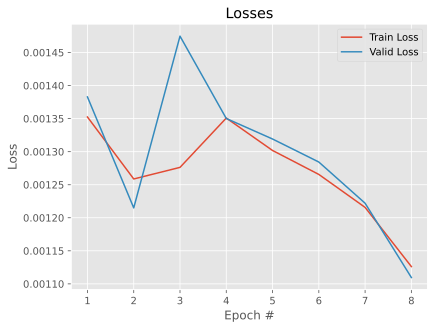

In [ ]:
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

## Predictions

In [ ]:
model.eval()
test_accuracy = n_examples = 0
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, target, text in tqdm_notebook(test_loader, leave=False):
        target = target.to(device)

        _, logits = model(inputs, return_activations=True)

        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1)
        target = target.cpu().numpy()

        y_true.extend(predictions)
        y_pred.extend(target)

print(classification_report(y_true, y_pred))

<ipython-input-16-f6e204b29981>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, target, text in tqdm_notebook(test_loader, leave=False):


  0%|          | 0/25 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.33      0.80      0.47      2629
           1       0.91      0.57      0.70      9801

    accuracy                           0.62     12430
   macro avg       0.62      0.68      0.59     12430
weighted avg       0.79      0.62      0.65     12430



In [ ]:
flatten = lambda x: [sublst for lst in x for sublst in lst]
inputs_lst, target_lst, text_lst = zip(*test_loader)
inputs_lst, target_lst, text_lst = map(flatten, [inputs_lst, target_lst, text_lst])
test_examples = list(zip(inputs_lst, target_lst, text_lst))

def print_random_prediction(n=10):
    to_emoji = lambda x: '😄' if x else '😡'
    model.eval()
    rows = []
    for _ in range(n):
        with torch.no_grad():
            inputs, target, text = random.choice(test_examples)
            target = target.item()

            _, logits = model([inputs], return_activations=True)
            logits = logits.detach().cpu().numpy()
            prediction = np.argmax(logits, axis=1)[0]

            predicted = to_emoji(prediction)
            actual = to_emoji(target)

            row = f"""
            <tr>
            <td>{text}&nbsp;</td>
            <td>{predicted}&nbsp;</td>
            <td>{actual}&nbsp;</td>
            </tr>
            """
            rows.append(row)

    rows_joined = '\n'.join(rows)
    table = f"""
<table>
<tbody>
<tr>
<td><b>Review</b>&nbsp;</td>
<td><b>Predicted</b>&nbsp;</td>
<td><b>Actual</b>&nbsp;</td>
</tr>
{rows_joined}
</tbody>
</table>
"""
    display(HTML(table))

In [ ]:
print_random_prediction(n=5)

#Exercises
1. Learn about Bidirectional LSTMs
2. Test the above text classifier without Bidirectional LSTMs
3. Add one more LSTM layer
4. Implement Attention mechanism to improve the performce.